In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# gpu = 1
import torch

In [2]:
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
    AutoTokenizer
)
from peft import get_peft_model, LoraConfig, TaskType, PeftModel, PeftConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import torch.nn.functional as F
from tqdm.auto import tqdm
import shutil
import re
import numpy as np
import random
import matplotlib.pyplot as plt



In [3]:
train_csv      = "/home/work/hhg/train_paragraph_balanced.csv"
test_csv      = "/home/work/.datasets/test.csv"
model_name     = "klue/roberta-base"
batch_size     = 32
learning_rate  = 1e-4
num_epochs     = 30
max_length     = 256
seed           = 42
# %%
checkpoint = "stop_tocken"
print(f"Checkpoint directory: {checkpoint}")

Checkpoint directory: stop_tocken


In [4]:
stopwords = {
    '가량', '가지', '각', '간', '갖은', '개', '개국', '개년', '개소', '개월', '걔', '거', '거기', '거리', '건', '것', '겨를', '격',
    '겸', '고', '군', '군데', '권', '그', '그거', '그것', '그곳', '그까짓', '그네', '그녀', '그놈', '그대', '그래', '그래도',
    '그서', '그러나', '그러니', '그러니까', '그러다가', '그러면', '그러면서', '그러므로', '그러자', '그런', '그런데', '그럼', '그렇지만',
    '그루', '그리고', '그리하여', '그분', '그이', '그쪽', '근', '근데', '글쎄', '글쎄요', '기', '김', '나', '나름', '나위', '남짓',
    '내', '냥', '너', '너희', '네', '네놈', '녀석', '년', '년대', '년도', '놈', '누구', '니', '다른', '다만', '단', '달', '달러',
    '당신', '대', '대로', '더구나', '더욱이', '데', '도', '동', '되', '두', '두세', '두어', '둥', '듯', '듯이', '등', '등등', '등지',
    '따라서', '따름', '따위', '딴', '때문', '또', '또는', '또한', '리', '마당', '마련', '마리', '만', '만큼', '말', '매', '맨', '명',
    '몇', '몇몇', '모', '모금', '모든', '무렵', '무슨', '무엇', '뭐', '뭣', '미터', '및', '바', '바람', '바퀴', '박', '발', '발짝',
    '번', '벌', '법', '별', '본', '부', '분', '뻔', '뿐', '살', '새', '서너', '석', '설', '섬', '세', '세기', '셈', '쇤네', '수', '순',
    '스무', '승', '시', '시간', '식', '씨', '아', '아냐', '아니', '아니야', '아무', '아무개', '아무런', '아아', '아이', '아이고', '아이구',
    '야', '약', '양', '얘', '어', '어느', '어디', '어머', '언제', '에이', '엔', '여기', '여느', '여러', '여러분', '여보', '여보세요',
    '여지', '역시', '예', '옛', '오', '오랜', '오히려', '온', '온갖', '올', '왜냐하면', '왠', '외', '요', '우리', '원', '월', '웬',
    '위', '음', '응', '이', '이거', '이것', '이곳', '이놈', '이래', '이런', '이런저런', '이른바', '이리하여', '이쪽', '일', '일대',
    '임마', '자', '자기', '자네', '장', '저', '저것', '저기', '저놈', '저런', '저쪽', '저편', '저희', '적', '전', '점', '제', '조',
    '주', '주년', '주일', '줄', '중', '즈음', '즉', '지', '지경', '지난', '집', '짝', '쪽', '쯤', '차', '참', '채', '척', '첫', '체',
    '초', '총', '측', '치', '큰', '킬로미터', '타', '터', '턱', '톤', '통', '투', '판', '퍼센트', '편', '평', '푼', '하기야', '하긴',
    '하물며', '하지만', '한', '한두', '한편', '허허', '헌', '현', '호', '혹은', '회', '흥'
}


In [5]:
from konlpy.tag import Okt

okt = Okt()

def remove_stopwords(text, stopwords_set):
    """
    형태소 분석 기반 불용어 제거
    """
    # 형태소 단위로 토큰화
    tokens = okt.morphs(text)
    
    # 불용어 제거
    filtered_tokens = [token for token in tokens if token not in stopwords_set]
    
    # 다시 문장으로 합치기
    return ' '.join(filtered_tokens)

In [6]:
from mecab import MeCab

mecab = MeCab()

from mecab import MeCab

mecab = MeCab()

# --- 2. 커스텀 토큰 붙이기 ---
def add_custom_tokens(text):
    """
    Mecab으로 형태소 분석 후, AI/인간 텍스트 판별에 도움이 되는 품사에 커스텀 토큰 붙이기
    """
    pos_tags = mecab.pos(text)

    # 품사별 붙일 토큰 정의 (판별용으로 추려서 구성)
    target_pos = {
        # --- 어미 ---
        'EF': '_EOS',    # 종결어미
        'EC': '_CON',    # 연결어미
        'ETM': '_MOD',   # 관형형 어미

        # --- 조사 ---
        'JKS': '_SUB',   # 주격 조사
        'JKO': '_OBJ',   # 목적격 조사
        'JKB': '_ADV',   # 부사격 조사
        'JKQ': '_QUOTE', # 인용격 조사

        # --- 부사 ---
        'MAG': '_ADV',      # 일반 부사
        'MAJ': '_CONADV',   # 접속 부사

        # --- 고유명사 ---
        'NNP': '_NAME',

        # --- 문장부호 ---
        'SF': '_PUNCT',  # 마침표
        'SE': '_PUNCT',  # 물음표, 느낌표
    }

    tokens = []
    for morph, pos in pos_tags:
        if pos in target_pos:
            tokens.append(morph + target_pos[pos])
        else:
            tokens.append(morph)
    return " ".join(tokens)



In [7]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

In [8]:
def clean_text(text):
    text = re.sub(r'\([^)]*\)', ' ', text)
    text = re.sub(r'[ㅎㅜㅠㅡ]+', ' ', text)
    text = re.sub(r'[\r\n]+', ' ', text)  
    text = re.sub(r'[^가-힣a-zA-Z0-9\s.!?]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [9]:
df = pd.read_csv(train_csv)
df = df.dropna(subset=['paragraph_text'])
df['paragraph_text'] = df['paragraph_text'].astype(str)
train_df, val_df = train_test_split(df,test_size=0.3,random_state=seed,stratify=df['generated'])

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # 이진 분류니까 2
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# --- AI/인간 판별용 special tokens 등록 ---
special_tokens = [
    '_EOS',     # 종결어미
    '_CON',     # 연결어미
    '_MOD',     # 관형형 어미
    '_SUB',     # 주격 조사
    '_OBJ',     # 목적격 조사
    '_ADV',     # 부사 / 부사격 조사
    '_CONADV',  # 접속 부사
    '_QUOTE',   # 인용격 조사
    '_NAME',    # 고유명사
    '_PUNCT'    # 문장부호
]

special_tokens_dict = {'additional_special_tokens': special_tokens}

# 토크나이저에 추가
tokenizer.add_special_tokens(special_tokens_dict)

# 모델 임베딩 크기 재조정
model.resize_token_embeddings(len(tokenizer))


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(32010, 768, padding_idx=1)

In [13]:
model.config.pad_token_id = model.config.eos_token_id
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05
)
model = get_peft_model(model, peft_config)
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(32010, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): Mo

In [14]:
class Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length


        # --- 전처리 한 번만 수행 + tqdm bar ---
        self.df = df.copy()
        self.df['processed_text'] = [
            add_custom_tokens(remove_stopwords(clean_text(text), stopwords))
            for text in tqdm(self.df['paragraph_text'], desc="Preprocessing")
        ]

        # special tokens 등록
        special_tokens = [
            '_EOS',     # 종결어미
            '_CON',     # 연결어미
            '_MOD',     # 관형형 어미
            '_SUB',     # 주격 조사
            '_OBJ',     # 목적격 조사
            '_ADV',     # 부사 / 부사격 조사
            '_CONADV',  # 접속 부사
            '_QUOTE',   # 인용격 조사
            '_NAME',    # 고유명사
            '_PUNCT'    # 문장부호
        ]
        special_tokens_dict = {'additional_special_tokens': special_tokens}
        self.tokenizer.add_special_tokens(special_tokens_dict)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row['processed_text']
        title = row['title']  # NEW: title 열 추가

        combined_text = f"[TITLE] {title} [SEP] {text}"  # NEW: 타이틀과 본문 결합
        
        inputs = self.tokenizer(
            combined_text,  # NEW: combined_text로 토큰화
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        
        item = {key: val.squeeze(0) for key, val in inputs.items()}
        item['generated'] = torch.tensor(row['generated'], dtype=torch.long)
        
        return item


In [15]:
train_dataset = Dataset(train_df, tokenizer, max_length=max_length)
val_dataset   = Dataset(val_df, tokenizer, max_length=max_length)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader    = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Preprocessing:   0%|          | 0/140996 [00:00<?, ?it/s]

Preprocessing:   0%|          | 0/60428 [00:00<?, ?it/s]

In [16]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import torch.nn.functional as F

def train(model, loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    all_preds, all_labels, all_probs = [], [], []
    progress_bar = tqdm(loader, desc="Training", leave=False)
    
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['generated'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")
    
    avg_loss = total_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else 0.5
    f1 = f1_score(all_labels, all_preds, average="macro")
    
    return avg_loss, acc, auc, f1, all_preds, all_labels


In [17]:
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels, all_probs = [], [], []
    progress_bar = tqdm(loader, desc="Validation", leave=False)
    
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['generated'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            total_loss += outputs.loss.item()
            logits = outputs.logits
            probs = F.softmax(logits, dim=1)[:, 1]
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            progress_bar.set_postfix(loss=f"{outputs.loss.item():.4f}")
    
    avg_loss = total_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else 0.5
    f1 = f1_score(all_labels, all_preds, average="macro")
    
    return avg_loss, acc, auc, f1, all_preds, all_labels

In [18]:
from sklearn.metrics import f1_score

def train_model(model, model_name, tokenizer, train_loader, val_loader, num_epochs, learning_rate, checkpoint):
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=total_steps
    )
    
    if not os.path.exists(checkpoint):
        os.makedirs(checkpoint)

    best_auc = 0.0
    train_losses, train_aucs, train_f1s = [], [], []
    val_losses, val_aucs, val_accs, val_f1s = [], [], [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_loss, train_acc, train_auc, train_f1, train_preds, train_labels = train(model, train_loader, optimizer, scheduler, device)
        val_loss, val_acc, val_auc, val_f1, val_preds, val_labels = evaluate(model, val_loader, device)
        
        train_losses.append(train_loss)
        train_aucs.append(train_auc)
        train_f1s.append(train_f1)

        val_losses.append(val_loss)
        val_aucs.append(val_auc)
        val_accs.append(val_acc)
        val_f1s.append(val_f1)
        
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train AUC: {train_auc:.4f} | Train F1: {train_f1:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f} | Val AUC: {val_auc:.4f} | Val F1: {val_f1:.4f}")

        adapter_ckpt = os.path.join(checkpoint, f"epoch{epoch+1}_auc{val_auc:.4f}")
        model.save_pretrained(adapter_ckpt)
        tokenizer.save_pretrained(adapter_ckpt)

        if val_auc > best_auc:
            best_auc = val_auc
            model.save_pretrained(os.path.join(checkpoint, "best_model"))
            tokenizer.save_pretrained(os.path.join(checkpoint, "best_model"))
            print(f"Best model saved: {adapter_ckpt}")

    # 손실, AUC, Accuracy, F1 곡선 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")

    ax2 = plt.gca().twinx()
    ax2.plot(train_aucs, label="Train AUC", color='blue')
    ax2.plot(val_aucs, label="Validation AUC", color='green')
    ax2.plot(val_accs, label="Validation Accuracy", color='orange')
    ax2.plot(val_f1s, label="Validation F1", color='red')
    ax2.set_ylabel("AUC / Accuracy / F1")
    ax2.legend(loc="upper right")

    plt.title("Loss, AUC, Accuracy, and F1 per Epoch")
    plt.grid(True)
    plt.show()

    torch.cuda.empty_cache()

In [19]:
# checkpoint_dir = f"{checkpoin}/epoch3_auc0.9985"  # ← 실제 디렉토리로 변경 필요

# model = AutoModelForSequenceClassification.from_pretrained(checkpoint_dir).to(device)
# tokenizer = AutoTokenizer.from_pretrained(checkpoint_dir)

model_name: klue/roberta-base
Checkpoint directory: stop_tocken
learning_rate: 0.0001
Using device: cuda
Epoch 1/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5851 | Train Acc: 0.6446 | Train AUC: 0.6712 | Train F1: 0.6176
Val   Loss: 0.5698 | Val   Acc: 0.6638 | Val AUC: 0.7051 | Val F1: 0.6276


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: stop_tocken/epoch1_auc0.7051
Epoch 2/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5707 | Train Acc: 0.6620 | Train AUC: 0.7038 | Train F1: 0.6431
Val   Loss: 0.5712 | Val   Acc: 0.6506 | Val AUC: 0.7157 | Val F1: 0.6500


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: stop_tocken/epoch2_auc0.7157
Epoch 3/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5630 | Train Acc: 0.6723 | Train AUC: 0.7190 | Train F1: 0.6570
Val   Loss: 0.5861 | Val   Acc: 0.6476 | Val AUC: 0.7259 | Val F1: 0.6476


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: stop_tocken/epoch3_auc0.7259
Epoch 4/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5531 | Train Acc: 0.6844 | Train AUC: 0.7377 | Train F1: 0.6728
Val   Loss: 0.5608 | Val   Acc: 0.6740 | Val AUC: 0.7424 | Val F1: 0.6729


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: stop_tocken/epoch4_auc0.7424
Epoch 5/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5431 | Train Acc: 0.6951 | Train AUC: 0.7550 | Train F1: 0.6862
Val   Loss: 0.5549 | Val   Acc: 0.6867 | Val AUC: 0.7630 | Val F1: 0.6864


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: stop_tocken/epoch5_auc0.7630
Epoch 6/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5312 | Train Acc: 0.7064 | Train AUC: 0.7714 | Train F1: 0.6995
Val   Loss: 0.5380 | Val   Acc: 0.7007 | Val AUC: 0.7766 | Val F1: 0.6999


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: stop_tocken/epoch6_auc0.7766
Epoch 7/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5175 | Train Acc: 0.7186 | Train AUC: 0.7886 | Train F1: 0.7132
Val   Loss: 0.5477 | Val   Acc: 0.6976 | Val AUC: 0.7908 | Val F1: 0.6974


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: stop_tocken/epoch7_auc0.7908
Epoch 8/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.5036 | Train Acc: 0.7311 | Train AUC: 0.8040 | Train F1: 0.7268
Val   Loss: 0.5762 | Val   Acc: 0.6861 | Val AUC: 0.7978 | Val F1: 0.6832


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: stop_tocken/epoch8_auc0.7978
Epoch 9/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.4906 | Train Acc: 0.7408 | Train AUC: 0.8181 | Train F1: 0.7374
Val   Loss: 0.5303 | Val   Acc: 0.7190 | Val AUC: 0.8120 | Val F1: 0.7190


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: stop_tocken/epoch9_auc0.8120
Epoch 10/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.4766 | Train Acc: 0.7533 | Train AUC: 0.8313 | Train F1: 0.7506
Val   Loss: 0.4928 | Val   Acc: 0.7464 | Val AUC: 0.8307 | Val F1: 0.7457


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: stop_tocken/epoch10_auc0.8307
Epoch 11/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.4631 | Train Acc: 0.7619 | Train AUC: 0.8435 | Train F1: 0.7596
Val   Loss: 0.5173 | Val   Acc: 0.7371 | Val AUC: 0.8387 | Val F1: 0.7366


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: stop_tocken/epoch11_auc0.8387
Epoch 12/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.4523 | Train Acc: 0.7692 | Train AUC: 0.8525 | Train F1: 0.7674
Val   Loss: 0.4871 | Val   Acc: 0.7552 | Val AUC: 0.8492 | Val F1: 0.7552


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: stop_tocken/epoch12_auc0.8492
Epoch 13/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.4415 | Train Acc: 0.7764 | Train AUC: 0.8608 | Train F1: 0.7748
Val   Loss: 0.5065 | Val   Acc: 0.7520 | Val AUC: 0.8519 | Val F1: 0.7518


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: stop_tocken/epoch13_auc0.8519
Epoch 14/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.4306 | Train Acc: 0.7845 | Train AUC: 0.8694 | Train F1: 0.7832
Val   Loss: 0.4585 | Val   Acc: 0.7724 | Val AUC: 0.8622 | Val F1: 0.7722


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: stop_tocken/epoch14_auc0.8622
Epoch 15/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.4192 | Train Acc: 0.7921 | Train AUC: 0.8772 | Train F1: 0.7910
Val   Loss: 0.4786 | Val   Acc: 0.7668 | Val AUC: 0.8670 | Val F1: 0.7665


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: stop_tocken/epoch15_auc0.8670
Epoch 16/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.4102 | Train Acc: 0.7971 | Train AUC: 0.8833 | Train F1: 0.7962
Val   Loss: 0.4654 | Val   Acc: 0.7773 | Val AUC: 0.8734 | Val F1: 0.7773


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: stop_tocken/epoch16_auc0.8734
Epoch 17/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.4016 | Train Acc: 0.8032 | Train AUC: 0.8892 | Train F1: 0.8024
Val   Loss: 0.4469 | Val   Acc: 0.7885 | Val AUC: 0.8813 | Val F1: 0.7885


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: stop_tocken/epoch17_auc0.8813
Epoch 18/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3930 | Train Acc: 0.8080 | Train AUC: 0.8947 | Train F1: 0.8073
Val   Loss: 0.4524 | Val   Acc: 0.7834 | Val AUC: 0.8844 | Val F1: 0.7830


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: stop_tocken/epoch18_auc0.8844
Epoch 19/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3847 | Train Acc: 0.8140 | Train AUC: 0.8996 | Train F1: 0.8134
Val   Loss: 0.4734 | Val   Acc: 0.7836 | Val AUC: 0.8836 | Val F1: 0.7831


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Epoch 20/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3781 | Train Acc: 0.8173 | Train AUC: 0.9033 | Train F1: 0.8168
Val   Loss: 0.4518 | Val   Acc: 0.7922 | Val AUC: 0.8907 | Val F1: 0.7919


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: stop_tocken/epoch20_auc0.8907
Epoch 21/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3730 | Train Acc: 0.8219 | Train AUC: 0.9066 | Train F1: 0.8213
Val   Loss: 0.4552 | Val   Acc: 0.7907 | Val AUC: 0.8947 | Val F1: 0.7899


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: stop_tocken/epoch21_auc0.8947
Epoch 22/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3676 | Train Acc: 0.8239 | Train AUC: 0.9093 | Train F1: 0.8234
Val   Loss: 0.4249 | Val   Acc: 0.8051 | Val AUC: 0.8979 | Val F1: 0.8051


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: stop_tocken/epoch22_auc0.8979
Epoch 23/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3617 | Train Acc: 0.8268 | Train AUC: 0.9125 | Train F1: 0.8264
Val   Loss: 0.4545 | Val   Acc: 0.7952 | Val AUC: 0.8950 | Val F1: 0.7948


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Epoch 24/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3559 | Train Acc: 0.8312 | Train AUC: 0.9157 | Train F1: 0.8308
Val   Loss: 0.4507 | Val   Acc: 0.8013 | Val AUC: 0.8976 | Val F1: 0.8010


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Epoch 25/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3530 | Train Acc: 0.8337 | Train AUC: 0.9174 | Train F1: 0.8333
Val   Loss: 0.4430 | Val   Acc: 0.8037 | Val AUC: 0.9011 | Val F1: 0.8034


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: stop_tocken/epoch25_auc0.9011
Epoch 26/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3489 | Train Acc: 0.8355 | Train AUC: 0.9195 | Train F1: 0.8352
Val   Loss: 0.4449 | Val   Acc: 0.8047 | Val AUC: 0.9008 | Val F1: 0.8044


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Epoch 27/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3439 | Train Acc: 0.8373 | Train AUC: 0.9218 | Train F1: 0.8370
Val   Loss: 0.4313 | Val   Acc: 0.8103 | Val AUC: 0.9047 | Val F1: 0.8101


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Best model saved: stop_tocken/epoch27_auc0.9047
Epoch 28/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3416 | Train Acc: 0.8388 | Train AUC: 0.9230 | Train F1: 0.8385
Val   Loss: 0.4358 | Val   Acc: 0.8086 | Val AUC: 0.9040 | Val F1: 0.8084


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Epoch 29/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3404 | Train Acc: 0.8401 | Train AUC: 0.9235 | Train F1: 0.8398
Val   Loss: 0.4375 | Val   Acc: 0.8081 | Val AUC: 0.9043 | Val F1: 0.8078


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Epoch 30/30


Training:   0%|          | 0/4407 [00:00<?, ?it/s]

Validation:   0%|          | 0/1889 [00:00<?, ?it/s]

Train Loss: 0.3386 | Train Acc: 0.8411 | Train AUC: 0.9246 | Train F1: 0.8408
Val   Loss: 0.4424 | Val   Acc: 0.8066 | Val AUC: 0.9038 | Val F1: 0.8063


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


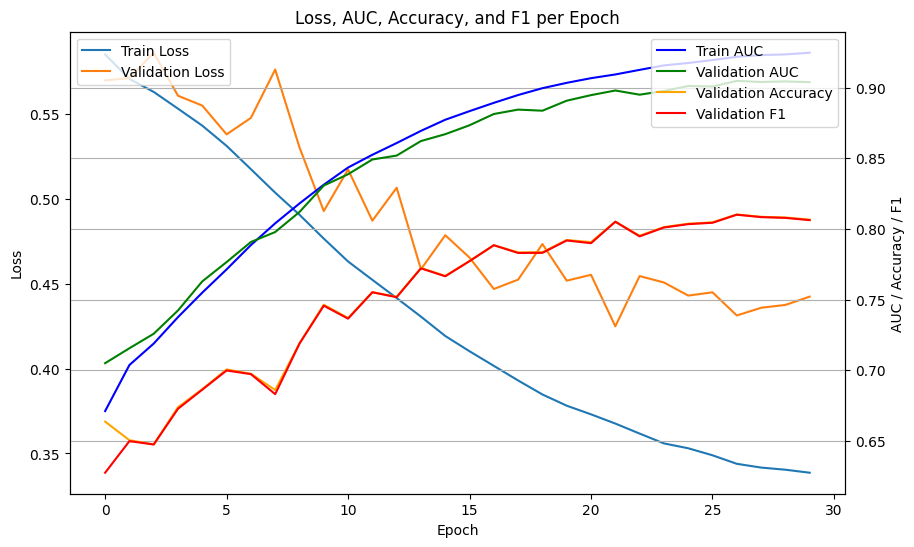

In [20]:
print(f"model_name: {model_name}")
print(f"Checkpoint directory: {checkpoint}")
print(f"learning_rate: {learning_rate}")

# 디바이스 재확인 및 모델 디바이스 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
print(f"Using device: {device}")

# train_model 호출
train_model(
    model,
    model_name,
    tokenizer,
    train_loader,
    val_loader,
    num_epochs,
    learning_rate,
    checkpoint
)

In [21]:
def predict(model, loader, device):
    model.eval()
    preds, probs = [], []
    bar = tqdm(loader, desc="Predicting", leave=False)
    with torch.no_grad():
        for batch in bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            prob = F.softmax(logits, dim=1)[:, 1]  # positive 확률

            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            probs.extend(prob.detach().float().cpu().numpy())  # bfloat16 → float32로 변환 후 numpy
    return preds, probs

In [22]:
import torch
from torch.utils.data import Dataset

class TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

        # --- 전처리 한 번만 수행 + tqdm bar ---
        self.df = df.copy()
        self.df['processed_text'] = [
            add_custom_tokens(remove_stopwords(clean_text(text), stopwords))
            for text in tqdm(self.df['paragraph_text'], desc="Preprocessing")
        ]

        # special tokens 등록
        special_tokens = [
            '_EOS',     # 종결어미
            '_CON',     # 연결어미
            '_MOD',     # 관형형 어미
            '_SUB',     # 주격 조사
            '_OBJ',     # 목적격 조사
            '_ADV',     # 부사 / 부사격 조사
            '_CONADV',  # 접속 부사
            '_QUOTE',   # 인용격 조사
            '_NAME',    # 고유명사
            '_PUNCT'    # 문장부호
        ]
        special_tokens_dict = {'additional_special_tokens': special_tokens}
        self.tokenizer.add_special_tokens(special_tokens_dict)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        text = row['processed_text']
        title = row['title']  # 타이틀 열

        # --- 타이틀 + 본문 결합 ---
        combined_text = f"[TITLE] {title} [SEP] {text}"

        # --- 토큰화 ---
        encoding = self.tokenizer(
            combined_text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors="pt"
        )

        return {
            'input_ids':      encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0)
        }


In [23]:
test_df = pd.read_csv(test_csv)
test_dataset  = TestDataset(test_df, tokenizer, max_length=max_length)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Preprocessing:   0%|          | 0/1962 [00:00<?, ?it/s]

In [24]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer

def load_lora_model(adapter_path, torch_dtype=None):
    """
    LoRA adapter 경로로부터 base model과 tokenizer를 로드하고,
    LoRA adapter를 적용한 모델과 tokenizer 반환.

    Args:
        adapter_path (str): 저장된 LoRA adapter 디렉토리 경로
        torch_dtype (torch.dtype, optional): 모델 로드 시 사용할 dtype (예: torch.bfloat16)

    Returns:
        model (PeftModel): LoRA adapter가 적용된 모델
        tokenizer (AutoTokenizer): 저장된 tokenizer
    """
    # 1. adapter config 로드
    peft_config = PeftConfig.from_pretrained(adapter_path, local_files_only=True)

    # 2. tokenizer 먼저 adapter_path에서 로드
    tokenizer = AutoTokenizer.from_pretrained(adapter_path, use_fast=True)

    # 2. base model 로드
    base_model = AutoModelForSequenceClassification.from_pretrained(
        peft_config.base_model_name_or_path,
        torch_dtype=torch_dtype
    )
    base_model.config.pad_token_id = base_model.config.eos_token_id

    # 4. tokenizer 사이즈에 맞게 임베딩 resize
    base_model.resize_token_embeddings(len(tokenizer))

    # 3. LoRA adapter 적용
    model = PeftModel.from_pretrained(base_model, adapter_path)

    return model, tokenizer


In [25]:
load_path = f"{checkpoint}/best_model"
model, tokenizer = load_lora_model(load_path, torch_dtype=torch.bfloat16)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

pred_labels, pred_probs = predict(model, test_loader, device)

sample_submission = pd.read_csv('/home/work/.datasets/sample_submission.csv', encoding='utf-8-sig')

# 확률로 저장
sample_submission_probs = sample_submission.copy()
sample_submission_probs['generated'] = pred_probs

# 저장 디렉토리
output_dir = f"/home/work/hhg/{checkpoint}"

output_path = os.path.join(output_dir, f"{checkpoint}_best.csv")
sample_submission_probs.to_csv(output_path, index=False)

print(f"파일이 저장되었습니다: {output_path}")


Predicting:   0%|          | 0/62 [00:00<?, ?it/s]

파일이 저장되었습니다: /home/work/hhg/stop_tocken/stop_tocken_best.csv
